In [85]:
#Multiple logistics regression using Google Tensor flow
from __future__ import print_function
import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import time
tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format
import seaborn as sns
import matplotlib.pyplot as plt
print(os.listdir("../input"))


['diabetes.csv']


In [86]:
#Read the file
DB1=pd.read_csv("../input/diabetes.csv")
DB1.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.6,50,1
1,1,85,66,29,0,26.6,0.4,31,0
2,8,183,64,0,0,23.3,0.7,32,1
3,1,89,66,23,94,28.1,0.2,21,0
4,0,137,40,35,168,43.1,2.3,33,1


In [87]:
#Check for null values
DB1.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

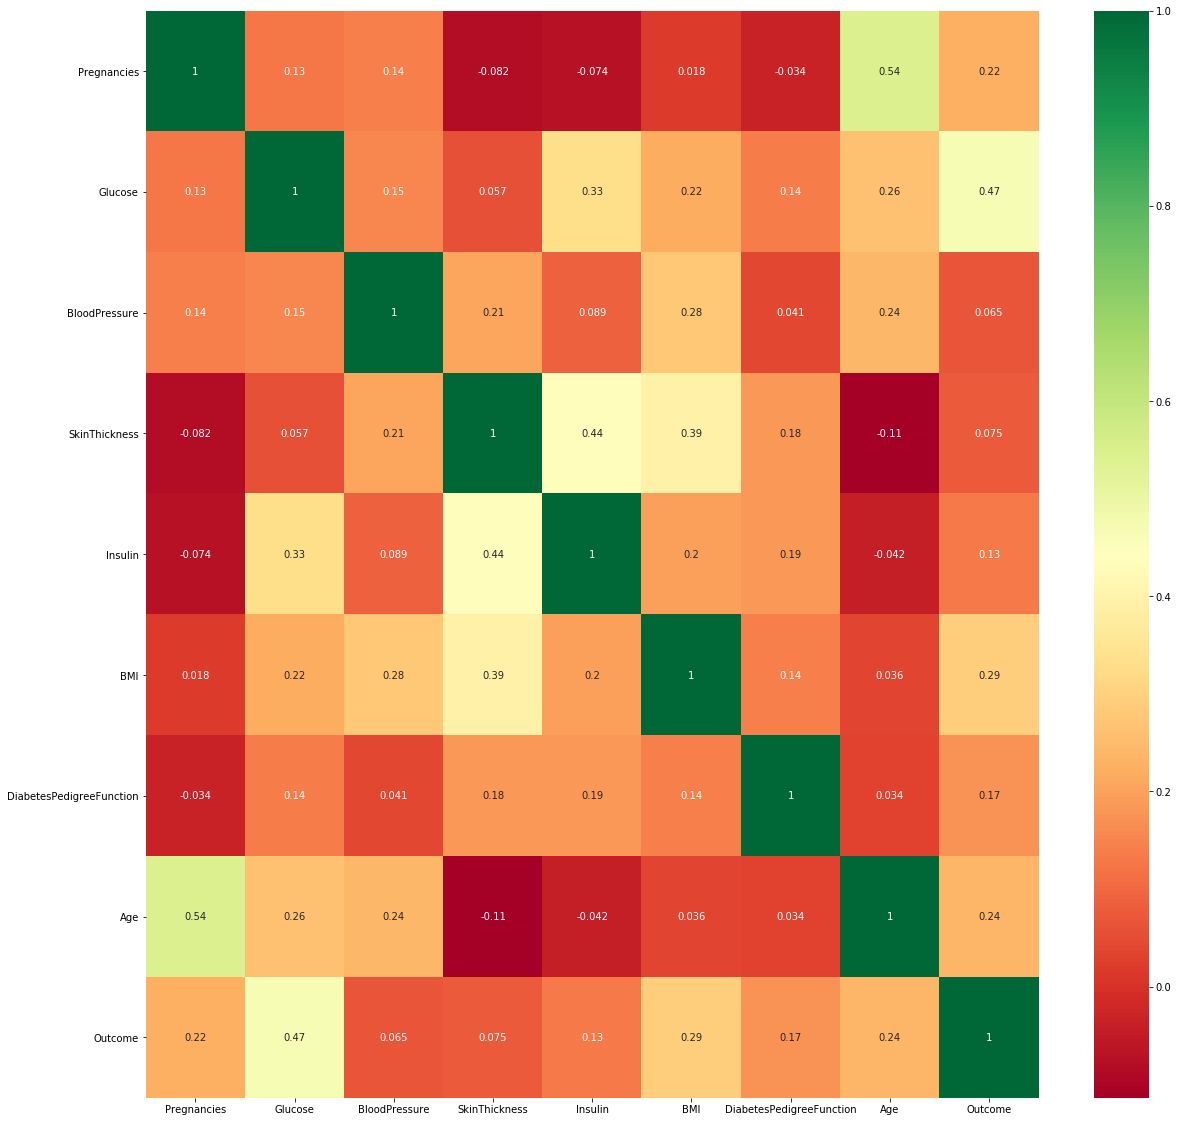

In [88]:
#Correlation states how the features are related to each other or the target variable.
#Correlation can be positive ie, increase in one value of feature increases the value of the target variable or
#negative ie,increase in one value of feature decreases the value of the target variable
#Heatmap makes it easy to identify which features are most related to the target variable.
#get correlations of each features in dataset
corr = DB1.corr()
top_corr_features = corr.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(DB1[top_corr_features].corr(),annot=True,cmap="RdYlGn")
#Verdict : Glucose, BMI and Age are having high correlation with diabetes

In [89]:
#Randomizing the data to make sure that no pathological ordering effects  the performance of Stochastic Gradient Descent.
DB2 = DB1.reindex(np.random.permutation(DB1.index))
DB2.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
7,10,115,0,0,0,35.3,0.1,29,0
343,5,122,86,0,0,34.7,0.3,33,0
353,1,90,62,12,43,27.2,0.6,24,0
685,2,129,74,26,205,33.2,0.6,25,0
71,5,139,64,35,140,28.6,0.4,26,0


In [90]:
#Examine the data
DB2.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.0,768.0,768.0,768.0,768.0,768.0,768.0,768.0,768.0
mean,3.8,120.9,69.1,20.5,79.8,32.0,0.5,33.2,0.3
std,3.4,32.0,19.4,16.0,115.2,7.9,0.3,11.8,0.5
min,0.0,0.0,0.0,0.0,0.0,0.0,0.1,21.0,0.0
25%,1.0,99.0,62.0,0.0,0.0,27.3,0.2,24.0,0.0
50%,3.0,117.0,72.0,23.0,30.5,32.0,0.4,29.0,0.0
75%,6.0,140.2,80.0,32.0,127.2,36.6,0.6,41.0,1.0
max,17.0,199.0,122.0,99.0,846.0,67.1,2.4,81.0,1.0


In [91]:
#Get the size of the data
DB2.shape

(768, 9)

In [92]:
#Split the data in to train and validate
DB3_Train=DB2.head(468)
DB3_Val=DB2.tail(300)

In [93]:
# Define the input feature
Diabetic_Feature_Train=DB3_Train[['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']]
Diabetic_Feature_Val=DB3_Val[['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']]

Diabetic_Feature_Train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
7,10,115,0,0,0,35.3,0.1,29
343,5,122,86,0,0,34.7,0.3,33
353,1,90,62,12,43,27.2,0.6,24
685,2,129,74,26,205,33.2,0.6,25
71,5,139,64,35,140,28.6,0.4,26


In [94]:
Diabetic_Feature_Val.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
250,9,106,52,0,0,31.2,0.4,42
337,5,115,76,0,0,31.2,0.3,44
486,1,139,62,41,480,40.7,0.5,21
42,7,106,92,18,0,22.7,0.2,48
602,1,124,74,36,0,27.8,0.1,30


In [95]:
# Define the label.
Diabetic_Targets_Train = DB3_Train["Outcome"]
Diabetic_Targets_Val= DB3_Val["Outcome"]

In [96]:
Diabetic_Targets_Train.head()

7      0
343    0
353    0
685    0
71     0
Name: Outcome, dtype: int64

In [97]:
Diabetic_Targets_Val.head()

250    0
337    1
486    0
42     0
602    0
Name: Outcome, dtype: int64

In [98]:
Diabetic_Feature_Train.shape,Diabetic_Targets_Train.shape,Diabetic_Feature_Val.shape,Diabetic_Targets_Val.shape

((468, 8), (468,), (300, 8), (300,))

In [99]:
#Perform logistics regression to compare with tensor flow
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(Diabetic_Feature_Train, Diabetic_Targets_Train)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [100]:
y_pred = logreg.predict(Diabetic_Feature_Val)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(Diabetic_Feature_Val, Diabetic_Targets_Val)))

Accuracy of logistic regression classifier on test set: 0.78


In [101]:
#Now  start preparing data for logistics regression for tensor flow
X=DB2.drop(labels=['Outcome'], axis=1).values
y=DB2.Outcome.values
X.shape,y.shape


((768, 8), (768,))

In [102]:
# set seed for numpy and tensorflow
# set for reproducible results
seed = 5
np.random.seed(seed)
tf.set_random_seed(seed)

In [103]:
# set replace=False, Avoid double sampling
train_index = np.random.choice(len(X), round(len(X) * 0.8), replace=False)

In [104]:
# diff set
test_index = np.array(list(set(range(len(X))) - set(train_index)))
train_X = X[train_index]
train_y = y[train_index]
test_X = X[test_index]
test_y = y[test_index]

In [105]:
# Begin building the model framework
# Declare the variables that need to be learned and initialization
# There are 8 features here, A's dimension is (8, 1)
A = tf.Variable(tf.random_normal(shape=[8, 1]))
b = tf.Variable(tf.random_normal(shape=[1, 1]))
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [106]:
# Define placeholders
data = tf.placeholder(dtype=tf.float32, shape=[None, 8])
target = tf.placeholder(dtype=tf.float32, shape=[None, 1])

In [107]:
# Declare the model you need to learn
mod = tf.matmul(data, A) + b

In [108]:
# Declare loss function
# Use the sigmoid cross-entropy loss function,
# first doing a sigmoid on the model result and then using the cross-entropy loss function
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=mod, labels=target))

In [109]:
# Define the learning rate， batch_size etc.
learning_rate = 0.003
batch_size = 30
iter_num = 1500

In [110]:
# Define the optimizer
opt = tf.train.GradientDescentOptimizer(learning_rate)

In [111]:
# Define the goal
goal = opt.minimize(loss)

In [112]:
# Define the accuracy
# The default threshold is 0.5, rounded off directly
prediction = tf.round(tf.sigmoid(mod))
# Bool into float32 type
correct = tf.cast(tf.equal(prediction, target), dtype=tf.float32)
# Average
accuracy = tf.reduce_mean(correct)
# End of the definition of the model framework

In [113]:
# Start training model
# Define the variable that stores the result
loss_trace = []
train_acc = []
test_acc = []

In [114]:
# training model
for epoch in range(iter_num):
    # Generate random batch index
    batch_index = np.random.choice(len(train_X), size=batch_size)
    batch_train_X = train_X[batch_index]
    batch_train_y = np.matrix(train_y[batch_index]).T
    sess.run(goal, feed_dict={data: batch_train_X, target: batch_train_y})
    temp_loss = sess.run(loss, feed_dict={data: batch_train_X, target: batch_train_y})
    # convert into a matrix, and the shape of the placeholder to correspond
    temp_train_acc = sess.run(accuracy, feed_dict={data: train_X, target: np.matrix(train_y).T})
    temp_test_acc = sess.run(accuracy, feed_dict={data: test_X, target: np.matrix(test_y).T})
    # recode the result
    loss_trace.append(temp_loss)
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    # output
    if (epoch + 1) % 300 == 0:
        print('epoch: {:4d} loss: {:5f} train_acc: {:5f} test_acc: {:5f}'.format(epoch + 1, temp_loss,
                                                                          temp_train_acc, temp_test_acc))

epoch:  300 loss: 3.066569 train_acc: 0.654723 test_acc: 0.616883
epoch:  600 loss: 11.169247 train_acc: 0.653094 test_acc: 0.616883
epoch:  900 loss: 4.557632 train_acc: 0.574919 test_acc: 0.603896
epoch: 1200 loss: 14.446397 train_acc: 0.656352 test_acc: 0.623377
epoch: 1500 loss: 13.012243 train_acc: 0.656352 test_acc: 0.610390


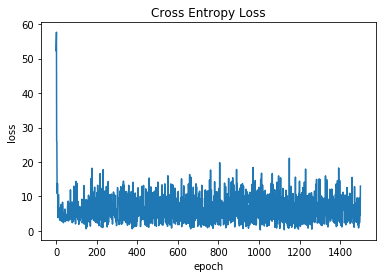

In [115]:
# Visualization of the results
# loss function
plt.plot(loss_trace)
plt.title('Cross Entropy Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

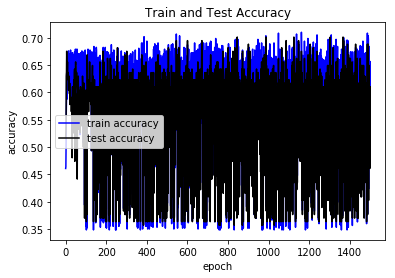

In [116]:
# accuracy
plt.plot(train_acc, 'b-', label='train accuracy')
plt.plot(test_acc, 'k-', label='test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Train and Test Accuracy')
plt.legend(loc='best')
plt.show()